# **Subset the LULCC data to shapefile**

By Bridget Bittmann

Date created: March 14, 2022

In [1]:
## IMPORT PACKAGES ##

import numpy as np #basic computation
!pip install geopandas
import geopandas as gpd #geopandas for .shp
import matplotlib.pyplot as plt #to create plots
import pandas as pd #to create dataframes and export .csv
!pip install rasterio
import rasterio as rso #import GeoTiff files
from rasterio.mask import mask #to crop data to a boundary
from rasterio.plot import show #to plot the image
from rasterio.crs import CRS
from shapely.ops import cascaded_union #creates boundary of shapefile
import json #imports metadata
!pip install rioxarray #to clip rasters to a .shp file
import rioxarray as rxr
from rasterio.warp import calculate_default_transform, reproject, Resampling
!pip install pylandstats
import pylandstats


     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 36.1 MB/s 
     |████████████████████████████████| 16.7 MB 329 kB/s 
     |████████████████████████████████| 19.3 MB 1.4 MB/s 
     |████████████████████████████████| 47 kB 2.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=4cef3cdabf6383722d6adc76390743719203e2257e328b37d702c2511d6dc865
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray
     |████████████████████████████████| 51 kB 27 kB/s 
     |████████████████████████████████| 84 kB 1.8 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 42 kB 818 kB/s 


Module /usr/local/lib/python3.7/dist-packages/pylandstats/landscape.py has not been compiled for Transonic-Pythran


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
## NAVIGATE TO YOUR DIRECTORY ##
%cd gdrive/MyDrive/spatial_colab/datasets/
%ls

/content/gdrive/MyDrive/spatial_colab/datasets
2005a.tif  2010.tif  2016.tif    2021.tif               IrrMapper/
2006.tif   2011.tif  2017.tif    CDL_reproject/         LBRB_shp/
2007a.tif  2012.tif  2018.tif    CDL_subsets/           subset_test_shp/
2007b.tif  2013.tif  2019.tif    diversion_timeseries/
2008.tif   2014.tif  2020.tif    irrigation_companies/
2009.tif   2015.tif  2021_clip/  irrig_lbrb/


In [4]:
## CREATE A FUNCTION TO SUBSET GEOSPATIAL DATA ##
## ------------------------------------------- ##

div_name = ['Middleton Irrigation Association and Middleton Mill Ditch', 'Phyllis Canal',
            'Riverside Canal', 'Settlers Irrigation District Ditch'] #list of div names on shapfile
shp_file = gpd.read_file('subset_test_shp/subset.shp') #open shapefile
data = rso.open('CDL_reproject/2009.tif') #open cdl image
# shp_file = shp_file.to_crs(data.crs) #reproject the shp file to same projection
extent = shp_file['geometry'] #get the geometry from shapefile
boundary = gpd.GeoSeries(cascaded_union(extent)) #gets the boundary of the whole extent
coords = [json.loads(boundary.to_json())['features'][0]['geometry']] #gets coordinates for rasterio input

# show(data)
print(data.crs)
# shp_file.boundary.plot()

EPSG:8826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  # Remove the CWD from sys.path while we load stuff.


In [5]:
## REPROJECT THE CDL FILES TO NAD83 ##

proj_name = 'EPSG:8826'
proj_name= CRS.from_epsg(8826)
input_imagery_file = 'CDL_subsets/2009.tif'
transformed_imagery_file = 'CDL_subsets/2009_trans.tif'
with rso.open(input_imagery_file) as imagery:
    transform, width, height = calculate_default_transform(imagery.crs, proj_name, imagery.width, imagery.height, *imagery.bounds)
    kwargs = imagery.meta.copy()
    kwargs.update({'crs': proj_name, 'transform': transform, 'width': width, 'height': height})
    with rso.open(transformed_imagery_file, 'w', **kwargs) as dst:
        for i in range(1, imagery.count + 1):
            reproject(
                source=rso.band(imagery, i),
                destination=rso.band(dst, i),
                src_transform=imagery.transform,
                src_crs=imagery.crs,
                dst_transform=transform,
                dst_crs=proj_name,
                resampling=Resampling.nearest)

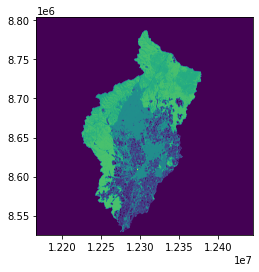

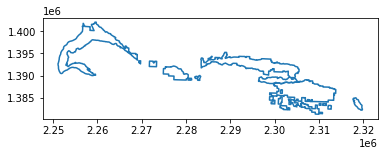

In [6]:
data = rso.open('CDL_subsets/2009_trans.tif')
coords = [json.loads(boundary.to_json())['features'][0]['geometry']] #gets coordinates for rasterio input
# out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
# out_meta = data.meta.copy()
show(data)
shp_file.boundary.plot()

In [7]:
from pylandstats import landscape

In [18]:
ls = landscape.Landscape('masked/Extract_RasE1.tif', nodata=0)
prop = ls.compute_class_metrics_df(metrics=['proportion_of_landscape'])


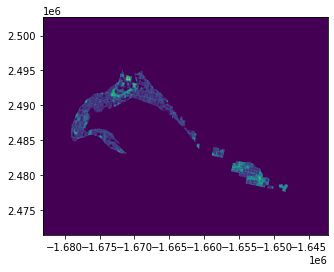

In [22]:
data = rso.open('masked/Extract_RasE1.tif')
landscape.Landscape.plot_landscape(ls)

In [20]:
display(prop)
len(prop)

,proportion_of_landscape
class_val,
1,11.265984
4,0.020319
6,0.005418
12,0.330516
14,0.001355
21,0.100238
23,0.205895
24,10.541287
28,0.161194


45